In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [371]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# data_dir_full = db.query('sess_name=="e16_3m2_211213"')['data_dir_full'][0]

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


load *SessionPulses.Events.mat failed


In [338]:
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False).iloc[:10]

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
e13_26m1    1  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e13_16f1    7  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_16...   
e13_26m1    2  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e16_3m2     3  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   
e16_3m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_3m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
e13_26m1    1  e13_26m1_211019      e13_26m1  2021-10-19   
e13_16f1    7  e13_16f1_210328      e13_16f1  2021-03-28   
e13_26m1    2  e13_26m1_211116      e13_26m1  2021-11-16   
e16_3m2     3   e16_3m2_211213       e16_3m2  2021-12-13   
e16_3m1     0   e16_3m1_210111       e16_3m1  2021-01-11   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
e13_26m1    1  ['alternation' 'alternation']     0.730769       78   
e13_16f1    7                    alternation     0.850000       20   
e13_26m1    2   ['alternation' 'linearMaze']     0.850000       20   
e16_3m2     3  ['alternation' 'alternation']     0.703704       54   
e16_3m1     0                    alternation     0.882353       17   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
e13_26m1    1           78        271             228  roman  roman_data  
e13_16f1    7           20        211             174  roman  roman_data  
e13_26m1    2           20        209             173  roman  roman_data  
e16_3m2     3           54        207             163  roman  roman_data  
e16_3m1     0           17        203             162  roman  roman_data

In [372]:
reload(pa)
cell_cols = cell_cols_d['pyr']
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_key='v',speed_thresh=1.,order=['smooth','divide'])
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [373]:
pf_res =pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v',load_only=True
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [374]:
# super hacky fix!!!!!!!! To make the truncated home cage field seem normal, by changing fields whose end is at 92/93 to 99
all_fields = {}
for k,val in pf_res['avg']['all_fields'].items():
    val.loc[(val['end']==92)|((val['end']==93)),'end']=99

    all_fields[k] = val
pf_res['avg']['all_fields']=all_fields

In [375]:
switch_res = saos.switch_analysis_one_session(data_dir_full,place_field_res=None,force_reload=False,nrepeats=1000,
                                              save_fn=saos.SAVE_FN(saos.FR_KEY),load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_highrepeats.p exists; loading---


In [376]:
all_fields_all_trialtype=pd.concat(pf_res['avg']['all_fields'],axis=0)

fr_map_concat,index_within_to_trial_index_df = pa.concat_fr_map_trial_df_d(fr_map_trial_df_d,spk_beh_df)

In [377]:
import misc
savefig_dir = 'coswitch_explore'
savefig_dir_full = misc.get_or_create_subdir(data_dir_full, 'py_figures',savefig_dir)
savefig_fn = 'coswitch_ratemap_per_trial'

In [378]:
changes_df_all = switch_res['avg']['changes_df'].loc[(slice(None),slice(None),0.3,'switch_magnitude',0.4)]

In [20]:
import change_point_post_analysis as cppa

/tmp/ipykernel_520562/2116323911.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind].loc[0.3,'switch_magnitude',0.4].dropna(axis=1)


In [253]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
def coswitch_ratemap_multipage(switch_res,pf_res,fr_map_trial_df_d,onoff=1,
                               fig_save_fn='fig_temp',fig_save_dir='./',
                               testmode=False,
                              ):
    lw = 3
    ls=':'
    
    fig_save_dir = misc.get_or_create_subdir('',fig_save_dir)
    fig_save_fn_full = os.path.join(fig_save_dir, f'{fig_save_fn}.pdf')
    
    trialtype_l = switch_res['avg']['X']['raw'].keys()
    with PdfPages(fig_save_fn_full) as pdf:
        for (task_ind,tt_ind) in trialtype_l:
            X_raw = None
            X_pwc = switch_res['avg']['X'][0.3][task_ind,tt_ind].dropna(axis=1)
            all_fields = pf_res['avg']['all_fields'][task_ind,tt_ind]
            changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind].loc[0.3,'switch_magnitude',0.4].dropna(axis=1)
            ntrials = changes_df.shape[1]
            
            if testmode:
                ntrials=1
            
            for t in range(ntrials):
                all_field_selected_coms, field_coms, nonfield_coms_selected = cppa.get_coswitching_examples_nonexamples_inds(X_raw,X_pwc, all_fields, changes_df, t,onoff=onoff,do_sort=False)
                nplots = all_field_selected_coms.shape[0]
                if nplots > 0:
                    fig,axs = ph.subplots_wrapper(nplots)
                    for ii in range(nplots):
                        ax = axs.ravel()[ii]
                        uid,field_id = all_field_selected_coms.index[ii]
                        com = all_field_selected_coms.iloc[ii]
                        field_st = all_fields.loc[uid,field_id]['start']
                        field_end = all_fields.loc[uid,field_id]['end']
                        frmap = fr_map_trial_df_d.loc[task_ind,tt_ind,uid].T.dropna(axis=0)
                        sns.heatmap(frmap,cmap='Greys',ax=ax)



                        # mark trial and field bounds
                        ax.hlines(t,*ax.get_xlim(),linewidth=lw,linestyle=ls,color='C0')
                        ax.vlines(field_st,*ax.get_ylim(),linewidth=lw,linestyle=ls,color='C1')
                        ax.vlines(field_end,*ax.get_ylim(),linewidth=lw,linestyle=ls,color='C1')
                        
                        ax.set_title(f'{uid},{field_id}')

                    fig.suptitle(f'task{task_ind}, trialtype{tt_ind}\n trial{t}')
                    plt.tight_layout()
                    pdf.savefig(figure=fig,bbox_inches='tight')
                    plt.close(fig=fig)

    
        
    
    
    

In [269]:
def ratemap_one(trial,all_fields,fr_map_trial_df_d,task_ind,tt_ind,uid,field_id,fig=None,ax=None,do_title=True,line_kws={},do_shuffle=False):
    line_kws_ = {'linewidth':3,'linestyle':':'}
    line_kws_.update(line_kws)
    if ax is None:
        fig,ax=plt.subplots()
    field_st = all_fields.loc[uid,field_id]['start']
    field_end = all_fields.loc[uid,field_id]['end']
    frmap = fr_map_trial_df_d.loc[task_ind,tt_ind,uid].T.dropna(axis=0)
    if do_shuffle: # circ shuffle trial
        ntrials = frmap.shape[0]
        shift_int = np.random.randint(1,ntrials-1)
        new_ind = np.roll(frmap.index,shift_int)
        frmap = frmap.iloc[new_ind]
    sns.heatmap(frmap,cmap='Greys',ax=ax)

    # mark trial and field bounds
    ax.hlines(trial,*ax.get_xlim(),color='C0',**line_kws_)
    ax.vlines(field_st,*ax.get_ylim(),color='C1',**line_kws_)
    ax.vlines(field_end,*ax.get_ylim(),color='C1',**line_kws_)
    if do_title:
        ax.set_title(f'{uid},{field_id}')
    return fig,ax

def ratemap_multiple(trial,all_field_selected_coms,all_fields,fr_map_trial_df_d,task_ind,tt_ind,do_title=True,do_suptitle=True,line_kws={},fig=None,axs=None,do_shuffle=False):
    nplots = all_field_selected_coms.shape[0]
    if nplots > 0:
        if axs is None:
            fig,axs = ph.subplots_wrapper(nplots)
        for ii in range(nplots):
            ax = axs.ravel()[ii]
            uid,field_id = all_field_selected_coms.index[ii]
            com = all_field_selected_coms.iloc[ii]
            fig,ax=ratemap_one(trial,all_fields,fr_map_trial_df_d,task_ind,tt_ind,uid,field_id,fig=fig,ax=ax,do_title=do_title,line_kws=line_kws,do_shuffle=do_shuffle)
        if do_suptitle:
            fig.suptitle(f'task{task_ind}, trialtype{tt_ind}\n trial{trial}')
        plt.tight_layout()
    return fig,axs

def coswitch_ratemap_onetrial(fr_map_trial_df_d,X_pwc, all_fields, changes_df, trial=1,onoff=1,do_title=True,seperate_ex_nonex=False,
                              line_kws = {'linewidth':3,'linestyle':':'},do_suptitle=True
                             ):
    all_field_selected_coms, field_coms, nonfield_coms_selected = cppa.get_coswitching_examples_nonexamples_inds(None,X_pwc, all_fields, changes_df, trial,onoff=onoff,do_sort=False)
    if not seperate_ex_nonex:
        fig,axs=ratemap_multiple(trial,all_field_selected_coms,all_fields,fr_map_trial_df_d,task_ind,tt_ind,line_kws=line_kws,do_suptitle=do_suptitle)
        return fig,axs
    else:
        fig_sel,axs_sel=ratemap_multiple(trial,field_coms,all_fields,fr_map_trial_df_d,task_ind,tt_ind,line_kws=line_kws,do_suptitle=do_suptitle)
        fig_non,axs_non=ratemap_multiple(trial,nonfield_coms_selected,all_fields,fr_map_trial_df_d,task_ind,tt_ind,line_kws=line_kws,do_suptitle=do_suptitle)
        return fig_sel,axs_sel, fig_non,axs_non



In [379]:
task_ind,tt_ind=0,0

X_raw = None
X_pwc = switch_res['avg']['X'][0.3][task_ind,tt_ind].dropna(axis=1)
all_fields = pf_res['avg']['all_fields'][task_ind,tt_ind]
changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind].loc[0.3,'switch_magnitude',0.4].dropna(axis=1)
trial_index = 1
all_field_selected_coms, field_coms, nonfield_coms_selected = cppa.get_coswitching_examples_nonexamples_inds(X_raw,X_pwc, all_fields, changes_df, trial_index,onoff=1,do_sort=False)






/tmp/ipykernel_520562/2116323911.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind].loc[0.3,'switch_magnitude',0.4].dropna(axis=1)


In [380]:
onoff = -1
(changes_df==onoff).sum(axis=0)

0      0
1      8
2      6
3     18
4     11
5     11
6      2
7     12
8      5
9     10
10     6
11     1
12     7
13     3
14     5
15     2
16     8
17     6
18     7
19     3
20     7
21     5
22     4
23     8
24     3
25     4
26     7
27     4
28     1
29     1
30     2
31     5
32     6
dtype: int64

<IPython.core.display.Javascript object>


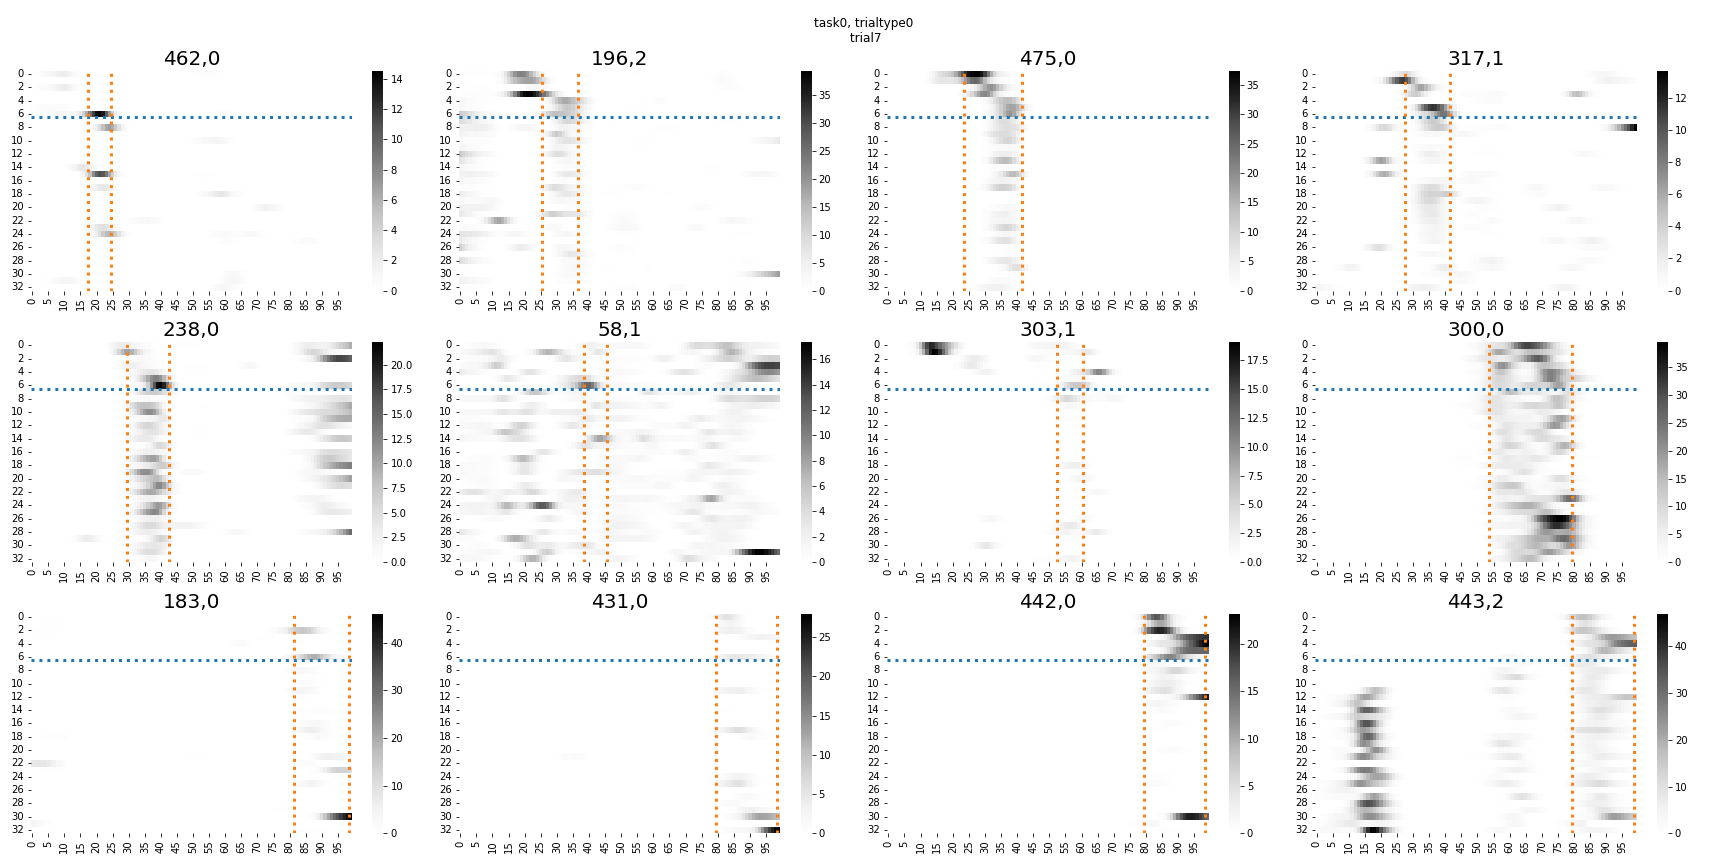

In [370]:
plt.ioff()
trial=7
onoff = -1
fig_sel,axs_sel, fig_non,axs_non=coswitch_ratemap_onetrial(fr_map_trial_df_d,X_pwc, all_fields, changes_df, trial=trial,onoff=onoff,do_title=True,seperate_ex_nonex=True)
plt.close(fig_non)
fig_sel


In [354]:
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913'

<IPython.core.display.Javascript object>


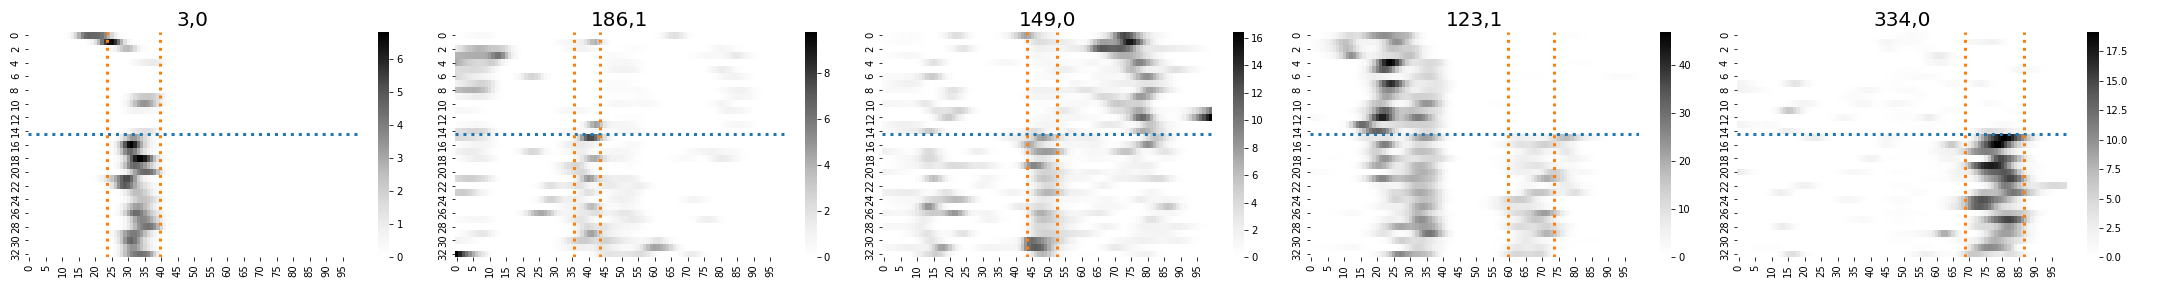

<IPython.core.display.Javascript object>


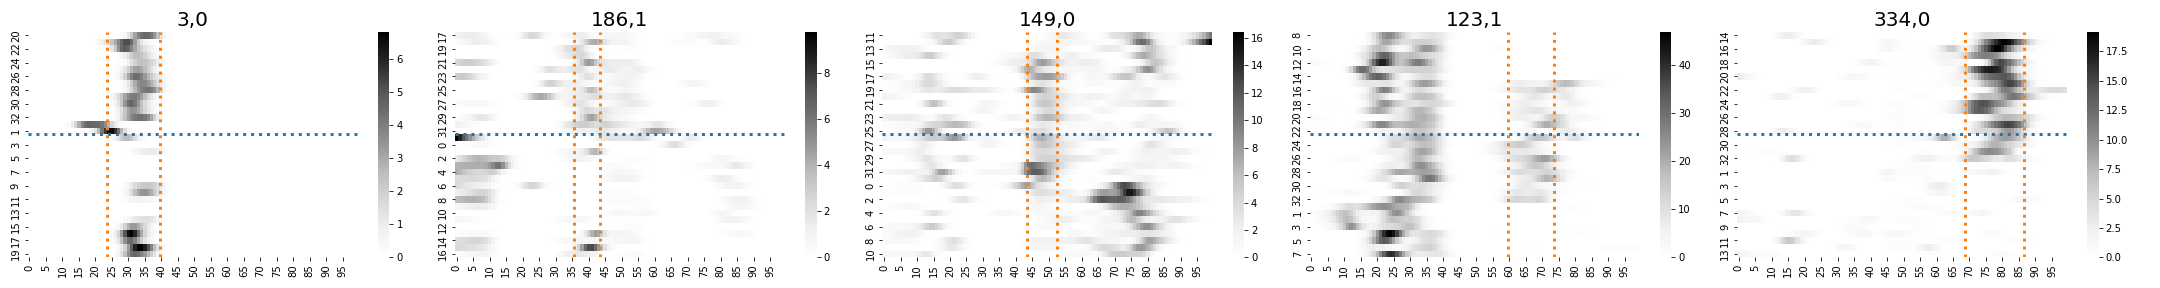

In [362]:
%matplotlib notebook
selected = [(3,0),(186,1),(149,0),(123,1),(334,0)]
nplots = len(selected)

trial = trial
selected=all_fields.loc[selected]

fig,axs = plt.subplots(1,nplots,figsize=(6*nplots,4))
fig,axs=ratemap_multiple(trial,selected,all_fields,fr_map_trial_df_d,task_ind,tt_ind,do_title=True,line_kws={},fig=fig,axs=axs,do_suptitle=False,do_shuffle=False)

fig_sh,axs_sh = plt.subplots(1,nplots,figsize=(6*nplots,4))
fig_sh,axs_sh=ratemap_multiple(trial,selected,all_fields,fr_map_trial_df_d,task_ind,tt_ind,do_title=True,line_kws={},fig=fig_sh,axs=axs_sh,do_suptitle=False,do_shuffle=True)



<IPython.core.display.Javascript object>


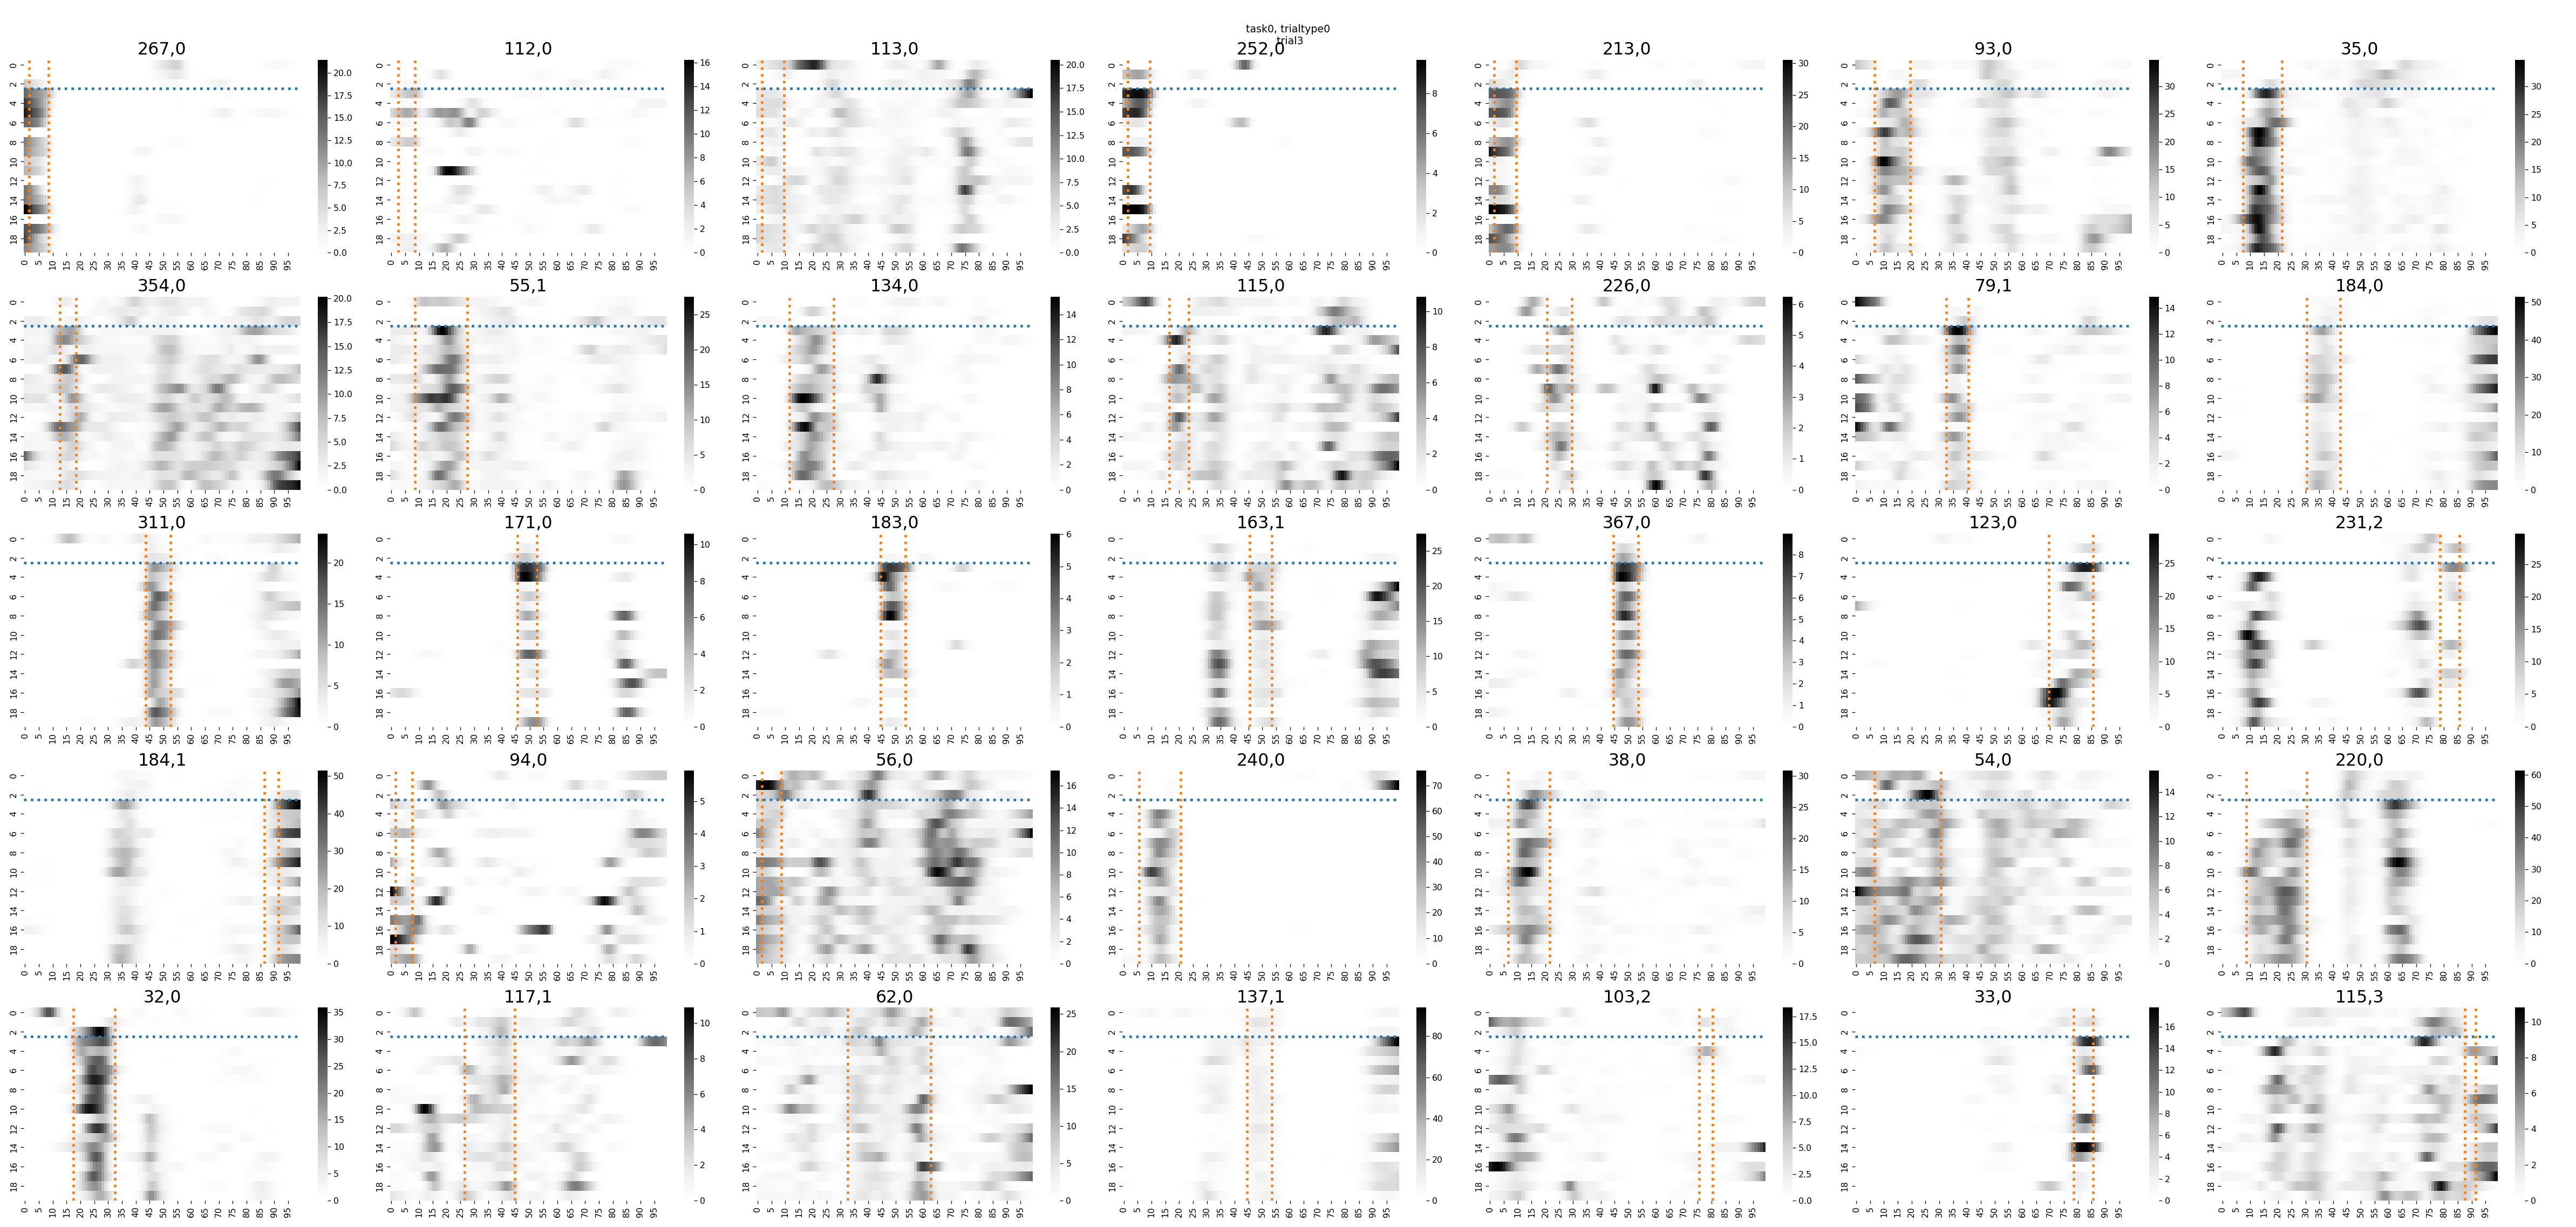

(<Figure size 3024x1440 with 70 Axes>, <AxesSubplot:title={'center':'115,3'}>)

In [104]:
%matplotlib notebook
coswitch_ratemap_onetrial(fr_map_trial_df_d,X_pwc, all_fields, changes_df, t=3,onoff=1,do_title=True)



In [93]:
%%time
coswitch_ratemap_multipage(switch_res,pf_res,fr_map_trial_df_d,onoff=1,
                               fig_save_fn='fig_temp',fig_save_dir='./',testmode=False
                              )

/tmp/ipykernel_520562/2900146700.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind].loc[0.3,'switch_magnitude',0.4].dropna(axis=1)
/tmp/ipykernel_520562/2900146700.py:19: PerformanceWarning: indexing past lexsort depth may impact performance.
  changes_df = switch_res['avg']['changes_df'].loc[task_ind,tt_ind].loc[0.3,'switch_magnitude',0.4].dropna(axis=1)


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
def coswitch_ratemap_multipage(plot_one_func,data_all,title_all=None,func_args=(),func_kwargs={}, nplots_per_page=20,fig_save_fn='fig_temp',fig_save_dir='./'):
    '''
    plot_one_func(data_one,*func_args,**func_kwargs)
    iterate this on all subplots
    
    data_all: list of data_one
    title_all: list or None

    '''
    plt.ioff()
    nplots = len(data_all)
    npages = int(np.ceil(nplots / nplots_per_page))
    plot_ind = 0
    fig_save_dir = misc.get_or_create_subdir('',fig_save_dir)
    fig_save_fn_full = os.path.join(fig_save_dir, f'{fig_save_fn}.pdf')


    with PdfPages(fig_save_fn_full) as pdf:
        for n in range(npages): 
            fig,axs = subplots_wrapper(nplots_per_page)
            for ii,ax in enumerate(axs.ravel()):
                try:
                    data_one = data_all[plot_ind]
                except IndexError:
                    break 
                _ =plot_one_func(data_one,fig=fig,ax=ax)
                if title_all is not None:
                    title = title_all[plot_ind]
                else:
                    title = plot_ind
                ax.set_title(title)
                plot_ind += 1
            pdb.set_trace()
            pdf.savefig(figure=fig,bbox_inches='tight')
            plt.close(fig=fig)
    
    print(f'{fig_save_fn_full} saved!',flush=True)